In [2]:

import numpy as np
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from unet import UNet
from load import StockImageDataset, WatermarkDataset
from tqdm.notebook import tqdm
import torchvision.models as models
from torchvision.io import read_image, ImageReadMode
import pathlib
from torchvision.transforms import Resize, CenterCrop

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
def load_from_path(path):
    image = read_image(str(path), ImageReadMode.RGB)
    orig_size = image.shape

    if image.dtype == torch.uint8:
        image = image.to(torch.float32) / 255.0
    elif torch.is_floating_point(image.dtype) and image.dtype != torch.float32:
        image = image.to(torch.float32)
    assert image.dtype == torch.float32, f'Type is {image.dtype}'
    # return image
    scale_height = 1024 / orig_size[1]
    scale_width = 1024 / orig_size[2]
    scale = min(scale_height, scale_width)
    resize_dim = tuple(int(dim * scale) for dim in orig_size[1:3])
    transform = Resize(resize_dim)
    crop_dim = tuple(dim - (dim % 16) for dim in resize_dim)
    cropping = CenterCrop(crop_dim)
    return transform(image)

In [18]:
model = UNet(4).to(device)

sd = torch.load('unet_training_1_80_sam.pt')
model.load_state_dict(sd['model'])

<All keys matched successfully>

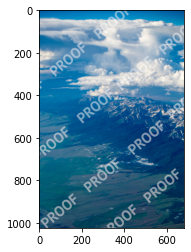

In [19]:
im_paths = [path for path in pathlib.Path('test_images').iterdir()]
images = [load_from_path(path) for path in im_paths]

for image in images:
    plt.figure()
    plt.imshow(image.cpu().numpy().transpose(1, 2, 0))

In [20]:
with torch.no_grad():
    removed = model.forward(images[0].to(device).unsqueeze(0))
    plt.figure()
    plt.imshow(removed.squeeze(0).cpu().numpy().transpose(1, 2, 0))

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 340 but got size 341 for tensor number 1 in the list.